In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from docplex.cp.model import *
import math
import random

In [2]:
taxi=pd.read_csv("data/taxi2000.csv")
pay=taxi['trip_distance'].tolist()

mu1=10
mu2=10

lam1=0.5
lam2=0.5
lam3=0

In [3]:
# natural formulation Intra5 + Inter3
def cplexF1_a5e3(pay_tem, icount,jcount ):
    
    male=range(0,jcount,2)
    female=range(1,jcount,2)

    dis=np.random.rand(icount,jcount)*0.5

    mdl = CpoModel('F1')
    M=integer_var_list(icount*jcount, 0, 1, "M") #integer_var_list()
    u=float_var_list(jcount,-100,100,'u')

    intra5=sum( (1-(u[j]+0.01)/1.01)**2 for j in range(jcount))
    muf=sum( (u[j]+0.01)/1.01 for j in female)/len(female)
    mum=sum( (u[j]+0.01)/1.01 for j in male)/len(male)
    inter3=(mum-muf)**2
    CustCare=sum(M[i*jcount+j]*dis[i,j] for i in range(icount) for j in range(jcount))

    obj=lam1*intra5+lam2*inter3+lam3*CustCare

    for j in range(jcount):
        mdl.add(1-sum(M[i*jcount+j] for i in range(icount)) >= 0)
        mdl.add(sum(M[i*jcount+j]*(pay_tem[i]-dis[i,j]) for i in range(icount)) == u[j])

    for i in range(icount):
        mdl.add(sum(M[i*jcount+j] for j in range(jcount))==1)

    mdl.minimize(obj)
    msol = mdl.solve(RelativeOptimalityTolerance=0.01,LogVerbosity='Quiet') 
    print(msol.get_solve_status())
    mlist=[]
    ulist=[]
    for ij in range(icount*jcount):
        mlist.append(msol.get_value(M[ij]))
    for j in range(jcount):
        ulist.append( sum(mlist[i*jcount+j]*(pay[i]-dis[i,j]) for i in range(icount)))
    
    return ulist

# natural formulation Intra5 + Inter2
def cplexF1_a5e2(pay_tem, icount,jcount ):
    
    male=range(0,jcount,2)
    female=range(1,jcount,2)

    dis=np.random.rand(icount,jcount)*0.5

    mdl = CpoModel('F1')
    M=integer_var_list(icount*jcount, 0, 1, "M")
    u=float_var_list(jcount,-100,100,'u')

    intra5=sum( (1-(u[j]+0.01)/1.01)**2 for j in range(jcount))
    mut=sum( (u[j]+0.01)/1.01 for j in range(jcount))/jcount
    muf=sum( (u[j]+0.01)/1.01 for j in female)/len(female)
    mum=sum( (u[j]+0.01)/1.01 for j in male)/len(male)
    inter2=len(female)*log(mut/muf)+len(male)*log(mut/mum)
    CustCare=sum(M[i*jcount+j]*dis[i,j] for i in range(icount) for j in range(jcount))

    obj=lam1*intra5+lam2*inter2+lam3*CustCare

    for j in range(jcount):
        mdl.add(1-sum(M[i*jcount+j] for i in range(icount)) >= 0)
        mdl.add(sum(M[i*jcount+j]*(pay_tem[i]-dis[i,j]) for i in range(icount)) == u[j])

    for i in range(icount):
        mdl.add(sum(M[i*jcount+j] for j in range(jcount))==1)

    mdl.minimize(obj)
    msol = mdl.solve(RelativeOptimalityTolerance=0.01) 
    print(msol.get_solve_status())
    mlist=[]
    ulist=[]
    for ij in range(icount*jcount):
        mlist.append(msol.get_value(M[ij]))
    for j in range(jcount):
        ulist.append( sum(mlist[i*jcount+j]*(pay[i]-dis[i,j]) for i in range(icount)))
    
    return ulist

# natural formulation Intra5 + Inter1
def cplexF1_a5e1(pay_tem, icount,jcount ):
    
    male=range(0,jcount,2)
    female=range(1,jcount,2)

    dis=np.random.rand(icount,jcount)*0.5

    mdl = CpoModel('F1')
    M=integer_var_list(icount*jcount, 0, 1, "M")
    u=float_var_list(jcount,-100,100,'u')

    intra5=sum( (1-(u[j]+0.01)/1.01)**2 for j in range(jcount))
    mut=sum( (u[j]+0.01)/1.01 for j in range(jcount))/jcount
    muf=sum( (u[j]+0.01)/1.01 for j in female)/len(female)
    mum=sum( (u[j]+0.01)/1.01 for j in male)/len(male)
    inter1=len(female)*(muf/mut)*log(muf/mut)+len(male)*(mum/mut)*log(mum/mut)
    CustCare=sum(M[i*jcount+j]*dis[i,j] for i in range(icount) for j in range(jcount))

    obj=lam1*intra5+lam2*inter1+lam3*CustCare

    for j in range(jcount):
        mdl.add(1-sum(M[i*jcount+j] for i in range(icount)) >= 0)
        mdl.add(sum(M[i*jcount+j]*(pay_tem[i]-dis[i,j]) for i in range(icount)) == u[j])

    for i in range(icount):
        mdl.add(sum(M[i*jcount+j] for j in range(jcount))==1)

    mdl.minimize(obj)
    msol = mdl.solve(RelativeOptimalityTolerance=0.01,LogVerbosity='Terse') 
    print(msol.get_solve_status())
    mlist=[]
    ulist=[]
    for ij in range(icount*jcount):
        mlist.append(msol.get_value(M[ij]))
    for j in range(jcount):
        ulist.append( sum(mlist[i*jcount+j]*(pay[i]-dis[i,j]) for i in range(icount)))
    
    return ulist

# natural formulation SÃ¼hr et al. 2019
def cplexF1_a5e0(pay_tem,icount,jcount ):
    # kdd 
    male=range(0,jcount,2)
    female=range(1,jcount,2)

    dis=np.random.rand(icount,jcount)*0.5

    mdl = CpoModel('F1')
    M=integer_var_list(icount*jcount, 0, 1, "M")
    u=float_var_list(jcount,-100,100,'u')

    intra5=sum( (1-(u[j]+0.01)/1.01)**2 for j in range(jcount))
    CustCare=sum(M[i*jcount+j]*dis[i,j] for i in range(icount) for j in range(jcount))

    obj=lam1*intra5+lam3*CustCare

    for j in range(jcount):
        mdl.add(1-sum(M[i*jcount+j] for i in range(icount)) >= 0)
        mdl.add(sum(M[i*jcount+j]*(pay_tem[i]-dis[i,j]) for i in range(icount)) == u[j])

    for i in range(icount):
        mdl.add(sum(M[i*jcount+j] for j in range(jcount))==1)

    mdl.minimize(obj)
    msol = mdl.solve(RelativeOptimalityTolerance=0.1,LogVerbosity='Terse') 
    print(msol.get_solve_status())
    mlist=[]
    ulist=[]
    for ij in range(icount*jcount):
        mlist.append(msol.get_value(M[ij]))
    for j in range(jcount):
        ulist.append( sum(mlist[i*jcount+j]*(pay[i]-dis[i,j]) for i in range(icount)))
    
    return ulist

def parityCal(u,jcount):
    male=range(0,len(u),2)
    female=range(1,len(u),2)

    mu1=10
    mu2=10
    
    mut=sum( (u[j]+0.01)/1.01 for j in range(jcount))/jcount
    muf=sum( (u[j]+0.01)/1.01 for j in female)/len(female)
    mum=sum( (u[j]+0.01)/1.01 for j in male)/len(male)
    
    intra2=sum( ((u[j]+0.01)/1.01/mut)*math.log((u[j]+0.01)/1.01/mut) for j in range(jcount))/jcount
    intra3=sum( math.log(1.01*mut/(u[j]+0.01)) for j in range(jcount) )/jcount
    intra4=sum( abs((u[j1]+0.01)/1.01 -(u[j2]+0.01)/1.01 ) for j1 in range(jcount)  for j2 in range(jcount) )/(2*mut*jcount**2)
    intra5=sum( abs(1-(u[j]+0.01)/1.01) for j in range(jcount))
    
    inter1=abs(len(female)*(muf/mut)*math.log(muf/mut)+len(male)*(mum/mut)*math.log(mum/mut))
    inter2=abs(len(female)*math.log(mut/muf)+len(male)*math.log(mut/mum))
    inter3=abs(mum-muf)
    
    return [intra2,intra3,intra4,intra5,inter1,inter2,inter3]

In [4]:
repeat=5
t=10
s=5
inter_name=['SÃ¼hr et al. 2019','Intra 5 + Inter 1','Intra 5 + Inter 2','Intra 5 + Inter 3']
ind_name=['intra2','intra3','intra4','intra5','inter1','inter2','inter3']
parity=pd.DataFrame(columns=ind_name+['size','inter_num'])
pay_start=random.randint(0,1999-t)
#pay_start=0
for ignore in range(repeat):
    u=cplexF1_a5e1(pay[pay_start:pay_start+t],s,t)
    par=parityCal(u,t)
    parity=parity.append({'intra2': par[0],'intra3': par[1],'intra4': par[2],'intra5': par[3],'inter1': par[4],'inter2': par[5],'inter3': par[6],'size':t,'inter_num':inter_name[1]}, ignore_index=True)

    u=cplexF1_a5e2(pay[pay_start:pay_start+t],s,t)
    par=parityCal(u,t)
    parity=parity.append({'intra2': par[0],'intra3': par[1],'intra4': par[2],'intra5': par[3],'inter1': par[4],'inter2': par[5],'inter3': par[6],'size':t,'inter_num':inter_name[2]}, ignore_index=True)

    u=cplexF1_a5e3(pay[pay_start:pay_start+t],s,t)
    par=parityCal(u,t)
    parity=parity.append({'intra2': par[0],'intra3': par[1],'intra4': par[2],'intra5': par[3],'inter1': par[4],'inter2': par[5],'inter3': par[6],'size':t,'inter_num':inter_name[3]}, ignore_index=True)

    u=cplexF1_a5e0(pay[pay_start:pay_start+t],s,t)
    par=parityCal(u,t)
    parity=parity.append({'intra2': par[0],'intra3': par[1],'intra4': par[2],'intra5': par[3],'inter1': par[4],'inter2': par[5],'inter3': par[6],'size':t,'inter_num':inter_name[0]}, ignore_index=True)
    
#parity.to_csv('data/exp1_repeat'+str(repeat)+'.csv',index=False)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


In [7]:
parity=pd.read_csv('data/exp1_repeat5.csv',header=0)
#par_size5=parity[parity['size']==5]
par=parity.drop(columns=['size','intra5'])
par=pd.melt(par,id_vars=['inter_num'],var_name='index',value_name='value')
par=par.rename(columns={'inter_num':'Formulation'})
par=par.replace('intra2', 'GE1')
par=par.replace('intra3', 'GE0')
par=par.replace('intra4', 'Gini')

<Figure size 2250x2625 with 0 Axes>

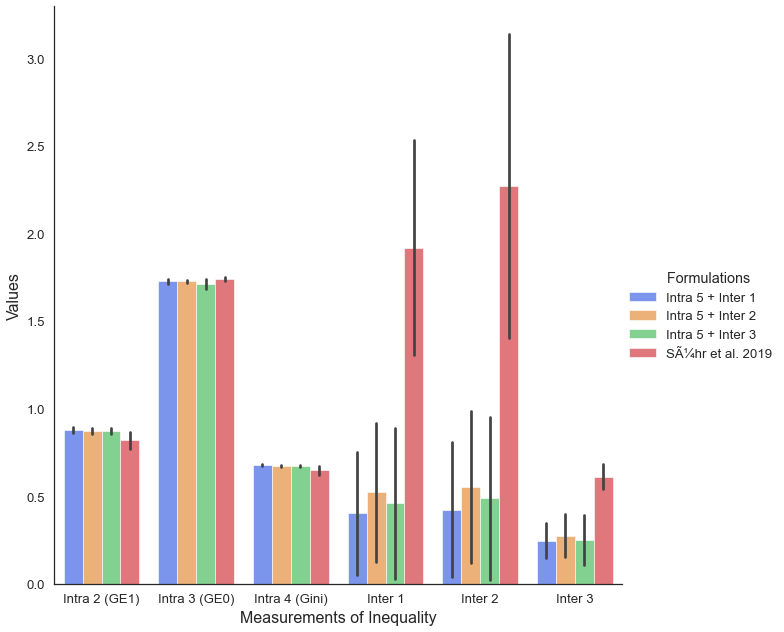

In [8]:
fig = plt.figure(figsize=(7.5/1,8.75/1), dpi=300)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('axes', labelsize=10) 
sns.set_theme(style="white",font_scale=1.2) #'axes.grid': True,'axes.facecolor': 'white',
g = sns.catplot(
    data=par, kind="bar",
    x='index', y='value', hue='Formulation',
    ci="sd", palette="bright", alpha=.6, legend_out = True,height=8.75/1.
)
g._legend.set_title('    Formulations')
g.set_xticklabels(['Intra 2 (GE1)','Intra 3 (GE0)','Intra 4 (Gini)','Inter 1','Inter 2','Inter 3'])
sns.set_style("white")
g.set_xlabels('Measurements of Inequality',fontsize=16)
g.set_ylabels('Values',fontsize=16) 

plt.savefig('plots/Fig1.tiff', bbox_inches = 'tight')